In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
from tqdm import tqdm
import re
from sklearn import metrics

In [2]:
import torch

In [3]:
import transformers

In [4]:
PROJECT_ROOT_PATH = Path('.').resolve().parent.parent
RAW_DATA_PATH = PROJECT_ROOT_PATH/'data/raw_data'

In [5]:
train_query = pd.read_csv(RAW_DATA_PATH/'./train/train.query.tsv',sep='\t',header=None)
train_query.columns=['id','q1']
train_reply = pd.read_csv(RAW_DATA_PATH/'./train/train.reply.tsv',sep='\t',header=None)
train_reply.columns=['id','id_sub','q2','label']
train_df = train_query.merge(train_reply, how='left')
train_df['q2'] = train_df['q2'].fillna('好的')
test_query = pd.read_csv(RAW_DATA_PATH/'./test/test.query.tsv',sep='\t',header=None, encoding='gbk')
test_query.columns = ['id','q1']
test_reply =  pd.read_csv(RAW_DATA_PATH/'./test/test.reply.tsv',sep='\t',header=None, encoding='gbk')
test_reply.columns=['id','id_sub','q2']
test_df = test_query.merge(test_reply, how='left')

In [6]:
train_df

,id,q1,id_sub,q2,label
0,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1
1,0,采荷一小是分校吧,1,是的,0
2,0,采荷一小是分校吧,2,这是5楼,0
3,1,毛坯吗？,0,因为公积金贷款贷的少,0
4,1,毛坯吗？,1,是呢,0
...,...,...,...,...,...
21580,5998,您好，我正在看尚林家园的房子,1,有啊,0
21581,5998,您好，我正在看尚林家园的房子,2,我带你看看,0
21582,5999,今天可以安排看房子吗？,0,我约下房东，稍后回你,1
21583,5999,今天可以安排看房子吗？,1,可以看，你几点有时间过来呢？,1


In [7]:
train_df.to_csv(RAW_DATA_PATH/'train/train.tsv', sep='\t', index=False, header=None)

In [8]:
train_query.head()

,id,q1
0,0,采荷一小是分校吧
1,1,毛坯吗？
2,2,你们的佣金费大约是多少和契税是多少。
3,3,靠近川沙路嘛？
4,4,这套房源价格还有优惠空间吗？


In [9]:
train_df.head()

,id,q1,id_sub,q2,label
0,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1
1,0,采荷一小是分校吧,1,是的,0
2,0,采荷一小是分校吧,2,这是5楼,0
3,1,毛坯吗？,0,因为公积金贷款贷的少,0
4,1,毛坯吗？,1,是呢,0


In [10]:
print(f'训练集问题数量：{len(train_query)}，答案数量：{len(train_reply)}')
print(f'测试集问题数量：{len(test_query)}，答案数量：{len(test_reply)}')

训练集问题数量：6000，答案数量：21585
测试集问题数量：14000，答案数量：53757


In [11]:
num_label = [0, 0]
for label in train_df['label']:
    num_label[label] += 1
print(f'训练集中正样本数量：{num_label[1]}，负样本数量：{num_label[0]}')

训练集中正样本数量：5387，负样本数量：16198


In [12]:
# func = lambda x: bool(re.search('[是]', str(x)))
# q1_bool = train_df['q1'].apply(func=func)
# q2_bool = train_df['q2'].apply(func=func)

In [13]:
# possible_df = train_df[train_df['q2'].apply(lambda x: bool(re.search('[是的]', str(x))))]
# # possible_df = train_df[q1_bool & q2_bool] 
# possible_df.to_csv(RAW_DATA_PATH/'./train/train.possible.tsv',sep='\t')

In [14]:
q_length = train_query['q1'].apply(func=lambda x: len(x)).sort_values()
a_length = train_reply['q2'].apply(func=lambda x: len(str(x))).sort_values()

#question: 6000, #answer: 21585
问题和回答的长度分布：


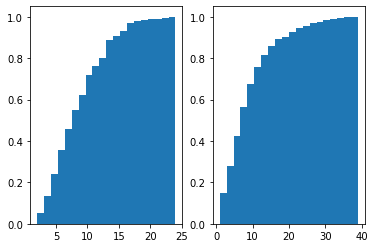

In [15]:
print(f'#question: {len(train_query)}, #answer: {len(train_reply)}')
print('问题和回答的长度分布：')
plt.subplot(121)
plt.hist(q_length[:-50], density=True, cumulative=True, bins=20)
plt.subplot(122)
plt.hist(a_length.sort_values()[:-500], density=True, cumulative=True, bins=20)
plt.show()

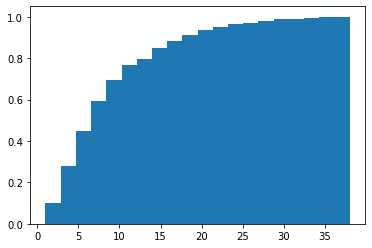

In [16]:
a_pos_length = train_reply['q2'][train_reply['label'] == 1].apply(func=lambda x: len(str(x))).sort_values()
plt.hist(a_pos_length.sort_values()[:-100], density=True, cumulative=True, bins=20)
plt.show()

In [17]:
answers = train_df[train_df['id'] == 100]
answers

,id,q1,id_sub,q2,label
355,100,带家具家电？,0,育文分校和魅力小学,0
356,100,带家具家电？,1,育文已经正式下文了,0
357,100,带家具家电？,2,已经在招生，咱想考虑那的房子我可以给您推荐几个好房子,0


In [18]:
answers['label']

355    0
356    0
357    0
Name: label, dtype: int64

In [19]:
pos_ratioes = {id: [0, 0] for id in train_query['id']}
for row in tqdm(train_df.itertuples()):
    pos_ratioes[row.id][row.label] += 1
for k, v in pos_ratioes.items():
    pos_ratioes[k] = v[1] / sum(v)

21585it [00:00, 498477.88it/s]


In [20]:
pos_neg_num = {id: [0, 0] for id in train_query['id']}
for row in tqdm(train_df.itertuples()):
    pos_neg_num[row.id][row.label] += 1

21585it [00:00, 496694.80it/s]


Ratio of queries without positive answers: 0.33566666666666667.


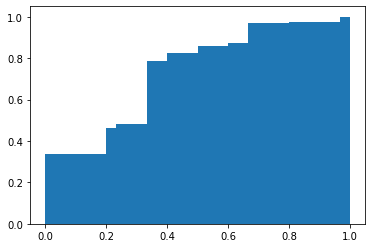

In [21]:
num_no_pos = 0
for v in pos_ratioes.values():
    if v == 0.0:
        num_no_pos += 1
print(f'Ratio of queries without positive answers: {num_no_pos/len(pos_ratioes)}.')
plt.hist(pos_ratioes.values(), bins=30, density=True, cumulative=True)
plt.show()

In [22]:
# train_df[train_df['label'] == 1].to_csv(RAW_DATA_PATH/'./train/train.pos.tsv',sep='\t',index=False)

In [23]:
train_query_bt = pd.read_csv(RAW_DATA_PATH/'./train/train.query.bt.tsv',sep='\t',header=None, names=['id','q1','q1_bt'])
train_query_bt

,id,q1,q1_bt
0,0,采荷一小是分校吧,采河第一小学是一所分校
1,1,毛坯吗？,空白？
2,2,你们的佣金费大约是多少和契税是多少。,你的佣金和契税是多少。
3,3,靠近川沙路嘛？,在川沙路附近吗？
4,4,这套房源价格还有优惠空间吗？,这房子的价格还有折扣吗？
...,...,...,...
5995,5995,好一起看一下,好的，我们看看
5996,5996,对口什么小学,什么小学
5997,5997,可以贷公积金吗,我能借公积金吗
5998,5998,您好，我正在看尚林家园的房子,你好，我在看上林家园的房子


In [24]:
train_query_bt['q1'] = train_query_bt['q1_bt']
train_query_bt = train_query_bt.drop('q1_bt', axis='columns')

In [25]:
train_reply_bt = pd.read_csv(RAW_DATA_PATH/'./train/train.reply.bt.tsv',sep='\t',header=None, names=['id','id_sub', 'q2', 'label','q2_bt'])
train_reply_bt

,id,id_sub,q2,label,q2_bt
0,0,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1,杭州财河第一小学钱江源校区、杭州钱江新城实验学校。
1,0,1,是的,0,对
2,0,2,这是5楼,0,这是五楼
3,1,0,因为公积金贷款贷的少,0,因为公积金贷款很少
4,1,1,是呢,0,是的
...,...,...,...,...,...
21580,5998,1,有啊,0,是的
21581,5998,2,我带你看看,0,我给你看
21582,5999,0,我约下房东，稍后回你,1,我去和房东约个时间。我待会再来找你
21583,5999,1,可以看，你几点有时间过来呢？,1,你可以看到。你什么时候有时间来？


In [26]:
train_reply_bt['q2'] = train_reply_bt['q2_bt']
train_reply_bt = train_reply_bt.drop('q2_bt', axis='columns')

In [27]:
train_df_bt = pd.merge(train_query_bt, train_reply_bt, how='left')
train_df_bt

,id,q1,id_sub,q2,label
0,0,采河第一小学是一所分校,0,杭州财河第一小学钱江源校区、杭州钱江新城实验学校。,1
1,0,采河第一小学是一所分校,1,对,0
2,0,采河第一小学是一所分校,2,这是五楼,0
3,1,空白？,0,因为公积金贷款很少,0
4,1,空白？,1,是的,0
...,...,...,...,...,...
21580,5998,你好，我在看上林家园的房子,1,是的,0
21581,5998,你好，我在看上林家园的房子,2,我给你看,0
21582,5999,你能安排今天去看房子吗？,0,我去和房东约个时间。我待会再来找你,1
21583,5999,你能安排今天去看房子吗？,1,你可以看到。你什么时候有时间来？,1


In [28]:
# 只增强正样本
# train_df_bt = train_df_bt[train_df_bt['label'] == 1]
# train_df_bt

In [29]:
train_df_bt['q2'] = train_df_bt['q2'].fillna('好的')

In [30]:
# 将增强的样本和原训练集合并
train_df_ex = pd.concat([train_df, train_df_bt])
train_df_ex

,id,q1,id_sub,q2,label
0,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1
1,0,采荷一小是分校吧,1,是的,0
2,0,采荷一小是分校吧,2,这是5楼,0
3,1,毛坯吗？,0,因为公积金贷款贷的少,0
4,1,毛坯吗？,1,是呢,0
...,...,...,...,...,...
21580,5998,你好，我在看上林家园的房子,1,是的,0
21581,5998,你好，我在看上林家园的房子,2,我给你看,0
21582,5999,你能安排今天去看房子吗？,0,我去和房东约个时间。我待会再来找你,1
21583,5999,你能安排今天去看房子吗？,1,你可以看到。你什么时候有时间来？,1


In [31]:
train_id_set = set([f'{x[0]},{x[1]}' for x in train_df[train_df['label'] == 1][['id', 'id_sub']].to_numpy()])
mask = train_df_bt[['id', 'id_sub']].apply(lambda x: f'{x["id"]},{x["id_sub"]}' in train_id_set, axis=1)
mask

0         True
1        False
2        False
3        False
4        False
         ...  
21580    False
21581    False
21582     True
21583     True
21584    False
Length: 21585, dtype: bool

In [32]:
train_df_bt[mask]

,id,q1,id_sub,q2,label
0,0,采河第一小学是一所分校,0,杭州财河第一小学钱江源校区、杭州钱江新城实验学校。,1
9,2,你的佣金和契税是多少。,1,所有费用降到654万,1
10,2,你的佣金和契税是多少。,2,包括税金、服务费和房价,1
14,3,在川沙路附近吗？,1,离川沙路有点近,1
16,4,这房子的价格还有折扣吗？,0,是的,1
...,...,...,...,...,...
21567,5994,价格能谈多少,1,五年来唯一的房子,1
21572,5996,什么小学,0,应该是长丰小学,1
21575,5997,我能借公积金吗,1,可忍受的,1
21582,5999,你能安排今天去看房子吗？,0,我去和房东约个时间。我待会再来找你,1


In [33]:
train_df_ex.to_csv(RAW_DATA_PATH/'train/train_ex.tsv', sep='\t', index=False, header=None)

In [34]:
# train_reply_bt[train_reply_bt['label'] == 1].to_csv(RAW_DATA_PATH/'./train/train.reply.bt.pos.tsv',sep='\t',index=False)

In [35]:
train_reply_aug = pd.read_csv(RAW_DATA_PATH/'./train/train.reply.aug4.tsv',sep='\t',header=None, names=['id','id_sub', 'q2', 'label', 'q2_aug_0', 'q2_aug_1', 'q2_aug_2', 'q2_aug_3', '_']).drop('_', axis=1)
train_reply_aug

,id,id_sub,q2,label,q2_aug_0,q2_aug_1,q2_aug_2,q2_aug_3
0,0,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1,杭州市采荷第一小学钱江景苑校区，杭州市钱江新城实验学校。,杭州市采荷第一小学钱江苑校区钱江杭州市，新城实验学校。,杭州市采荷第一小学钱江苑校区，钱江新城实验学校,杭州市采荷第一小学钱江苑校区，杭州市钱江新城滨江实验学校。
1,0,1,是的,0,是的,是的,的,是的
2,0,2,这是5楼,0,楼5这是,这是5六楼,这是5楼,这是四楼5楼
3,1,0,因为公积金贷款贷的少,0,因为公积金贷的少,因为按揭贷款贷款贷的少,因为公积金贷款贷的少,因为授信公积金贷款贷的少
4,1,1,是呢,0,呢是,呢是,是呢,是即是呢
...,...,...,...,...,...,...,...,...
21580,5998,1,有啊,0,啊有,有,有需要有啊,啊有
21581,5998,2,我带你看看,0,我带你问问,我带看看,我带你看看,我看看你带
21582,5999,0,我约下房东，稍后回你,1,中约我约下房东，稍后回你,我约下房东，稍后回你,我约下随后房东，稍后回你,我约下房东，稍后完你
21583,5999,1,可以看，你几点有时间过来呢？,1,可以看，你几点有时间过来呢？,可以看，几点有时间过来呢？,可以看，你几点有时间过来呢可？,可以看，你几点有时间延迟过来呢？


In [36]:
train_query_aug = pd.read_csv(RAW_DATA_PATH/'./train/train.query.aug4.tsv',sep='\t',header=None, names=['id','q1','q1_aug_0', 'q1_aug_1', 'q1_aug_2', 'q1_aug_3', '_']).drop(['_'], axis=1)
train_query_aug

,id,q1,q1_aug_0,q1_aug_1,q1_aug_2,q1_aug_3
0,0,采荷一小是分校吧,采荷普渡大学一小是分校吧,采荷一小即是是分校吧,采荷一小是吧,分校一小是采荷吧
1,1,毛坯吗？,毛坯吗？,马尔松吗？,毛坯吗？,Loiron吗？
2,2,你们的佣金费大约是多少和契税是多少。,你们的佣金费大约是多少和可否是多少。,你们的佣金费是多少和契税是多少。,你们的会员费费大约是多少和契税是多少。,你们的佣金费是多少和契税是多少。
3,3,靠近川沙路嘛？,嘛靠近川沙路嘛？,靠近川沙嘛路？,靠近川沙路邻近嘛？,靠近川沙？嘛路
4,4,这套房源价格还有优惠空间吗？,这套房源价格折扣还有优惠空间吗？,这套房源价格还有空间优惠吗？,这套房源价格？优惠空间吗还有,这套房源价格还有优惠空间吗？
...,...,...,...,...,...,...
5995,5995,好一起看一下,好看一起一下,好再说一起看一下,一起看一下,好一起看顺便
5996,5996,对口什么小学,阿勒泰地区什么小学,对口什么小学,对口小学什么,对口
5997,5997,可以贷公积金吗,公积金贷可以吗,可以贷表外公积金吗,可以贷公积金吗,能可以贷公积金吗
5998,5998,您好，我正在看尚林家园的房子,您好，我正看尚林家园的房子,您好，我正在看尚林家园的房子,您好，我指路正在看尚林家园的房子,您好，家园正在看尚林我的房子


In [37]:
from collections import defaultdict

In [38]:
train_reply_aug_dict = defaultdict(list)
for row in tqdm(train_reply_aug.itertuples(index=False)):
    idx = row.id
    idx_sub = row.id_sub
    label = row.label
    samples = [row.q2] + list(row[4:])
    num_samples = len(samples)

    train_reply_aug_dict['id'].extend([idx] * num_samples)
    train_reply_aug_dict['id_sub'].extend([idx_sub] * num_samples)
    train_reply_aug_dict['label'].extend([label] * num_samples)
    train_reply_aug_dict['q2'].extend(samples)

21585it [00:00, 224468.12it/s]


In [39]:
train_query_aug_dict = defaultdict(list)
for row in tqdm(train_query_aug.itertuples(index=False)):
    idx = row.id
    samples = list(row[1:])
    num_samples = len(samples)

    train_query_aug_dict['id'].extend([idx] * num_samples)
    train_query_aug_dict['q1'].extend(samples)

6000it [00:00, 323730.32it/s]


In [40]:
train_query_aug = pd.DataFrame(data=train_query_aug_dict)

In [41]:
train_reply_aug = pd.DataFrame(data=train_reply_aug_dict)

In [42]:
train_df_aug_answer_only = pd.merge(train_query, train_reply_aug, how='left')
train_df_aug_answer_only = train_df_aug_answer_only[['id', 'q1', 'id_sub', 'q2', 'label']]
train_df_aug_answer_only

,id,q1,id_sub,q2,label
0,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1
1,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江景苑校区，杭州市钱江新城实验学校。,1
2,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区钱江杭州市，新城实验学校。,1
3,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，钱江新城实验学校,1
4,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城滨江实验学校。,1
...,...,...,...,...,...
107920,5999,今天可以安排看房子吗？,2,好的，那咱们在一号门口这碰头？,0
107921,5999,今天可以安排看房子吗？,2,好或者说的，那咱们在一号门口这碰头？,0
107922,5999,今天可以安排看房子吗？,2,，咱们在一号门口这？,0
107923,5999,今天可以安排看房子吗？,2,好在，那咱们的一号门口这碰头？,0


In [43]:
train_df_aug_answer_only.to_csv(RAW_DATA_PATH/'train/train_aug_answer_only.tsv', sep='\t', index=False, header=None)

In [44]:
train_df_aug_query_only = pd.merge(train_query_aug, train_reply, how='left')
train_df_aug_query_only

,id,q1,id_sub,q2,label
0,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1
1,0,采荷一小是分校吧,1,是的,0
2,0,采荷一小是分校吧,2,这是5楼,0
3,0,采荷普渡大学一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1
4,0,采荷普渡大学一小是分校吧,1,是的,0
...,...,...,...,...,...
107920,5999,今天可以安排看房子？吗,1,可以看，你几点有时间过来呢？,1
107921,5999,今天可以安排看房子？吗,2,好的，那咱们在一号门口这碰头？,0
107922,5999,现在可以安排看房子吗？,0,我约下房东，稍后回你,1
107923,5999,现在可以安排看房子吗？,1,可以看，你几点有时间过来呢？,1


In [45]:
train_df_aug_query_only.to_csv(RAW_DATA_PATH/'train/train_aug_query_only.tsv', sep='\t', index=False, header=None)

In [46]:
train_df_aug_full = pd.merge(train_query_aug, train_reply_aug, how='left')
train_df_aug_full = train_df_aug_full[['id', 'q1', 'id_sub', 'q2', 'label']]

In [50]:
pd.Series().to_list()

[]

In [48]:
train_df_aug_full

,id,q1,id_sub,q2,label
0,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城实验学校。,1
1,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江景苑校区，杭州市钱江新城实验学校。,1
2,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区钱江杭州市，新城实验学校。,1
3,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，钱江新城实验学校,1
4,0,采荷一小是分校吧,0,杭州市采荷第一小学钱江苑校区，杭州市钱江新城滨江实验学校。,1
...,...,...,...,...,...
539620,5999,现在可以安排看房子吗？,2,好的，那咱们在一号门口这碰头？,0
539621,5999,现在可以安排看房子吗？,2,好或者说的，那咱们在一号门口这碰头？,0
539622,5999,现在可以安排看房子吗？,2,，咱们在一号门口这？,0
539623,5999,现在可以安排看房子吗？,2,好在，那咱们的一号门口这碰头？,0


In [47]:
train_df_aug_full.to_csv(RAW_DATA_PATH/'train/train_aug_full.tsv', sep='\t', index=False, header=None)

In [100]:
# from nltk.util import ngrams
# ns = list(range(1, 4))
# def get_ngram_vector(grams, vocab):
#     v = np.zeros(shape=[len(vocab)])
#     for g in grams: 
#         if g in vocab:
#             v[vocab[g]] += 1
#     return v

In [101]:
# vocab = {'n': 0, 'haha': 1}
# grams = ['n', 'haha', 'n', '', 'haha', 2342]
# get_ngram_vector(grams, vocab)

In [102]:
# def get_ngram(sequence, n):
#     return [''.join(x) for x in ngrams(sequence=sequence, n=n)]

In [103]:
# get_ngram('nihao', 3)

In [104]:
# # from sklearn.metrics.pairwise import cosine_similarity
# from numpy import dot
# from numpy.linalg import norm
# def cos_sim(a, b):
    # return dot(a, b)/(norm(a)*norm(b))

In [99]:
# for i, sample in tqdm(enumerate(train_query_aug.itertuples(index=False))):
#     org_q = sample[1]
#     org_grams = []
#     for n in ns:
#         org_grams.extend(get_ngram(org_q, n))
#     vocab = dict(zip(set(org_grams), range(len(org_grams))))
#     # print(vocab)
#     org_v = get_ngram_vector(org_grams, vocab)

#     aug_qs = sample[2:]
#     aug_vs = np.zeros(shape=[4, len(vocab)])
#     for i, aug_q in enumerate(aug_qs):
#         aug_grams = []
#         for n in ns:
#             aug_grams.extend(get_ngram(aug_q, n))
#         aug_v = get_ngram_vector(aug_grams, vocab)
#         aug_vs[i] = aug_v

#     sims = [cos_sim(org_v, v) for v in aug_vs]
#     print(sims)
#     print(org_q)
#     print(aug_qs)

In [41]:
import transformers

In [43]:
tokenizer = transformers.BertTokenizer.from_pretrained('../pretrain_model/bert-base-chinese/vocab.txt')

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [50]:
tokenizer.encode_plus('你好啊小老弟')

{'input_ids': [101, 872, 1962, 1557, 2207, 5439, 2475, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [51]:
tokenizer.encode_plus(list('你好啊小老弟'))

{'input_ids': [101, 872, 1962, 1557, 2207, 5439, 2475, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [53]:
tokenizer('你好啊小老弟')

{'input_ids': [101, 872, 1962, 1557, 2207, 5439, 2475, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}